In [285]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy.ndimage as ndi 
import rawpy as rp
import pylab as pl 
from IPython import display
import time
from collections import defaultdict
import os




In [346]:

directory = r'C:\Users\Nicla\OneDrive\Documents\University\Master\Practical Couse M\antibiotic_persistance\Lab_Course_Edelkoetter_Weisel'  # Replace with the actual directory path

# Get the distance between the images of the same sample
file_names = os.listdir(directory)
for i,f in enumerate(file_names):
    if i == len(file_names)-1:
        break
    if f[:15] != file_names[i+1][:15]:
        distance = i
        break



# Create a dictionary with the sample number as key and a list of the file names as values
samples_name_dict = defaultdict(list)
for i in range(int((len(file_names)-1)/(distance+1))):
    samples_name_dict[i+1]= file_names[((distance+1)*i):((distance+1)*(i+1))]
    if False: #set to True to convince yourself that the files are sorted correctly
        file_names_1 = file_names[((distance+1)*i):((distance+1)*(i+1))]
        print(file_names_1[0][:15], file_names_1[-1][:15], 'date:', file_names_1[0][16:-4],file_names_1[-1][16:-4])
        print(len(file_names_1))

# Create a dictionary with the sample number as key and a list of the time of the images as values        
samples_time_dict = defaultdict(list)
for key in samples_name_dict.keys():
    time_list = []
    for file_name in samples_name_dict[key]:
        date = time.strptime(file_name[16:-4], '%Y-%m-%d_%H-%M-%S')
        time_list.append(date)
    samples_time_dict[key] = time_list


In [240]:
"""Importing images"""

name_pct = 'd000661_350_002_2024-11-28_09-22-47.CR2'
raw_background = rp.imread('d000661_350_002_2024-11-27_18-22-41.CR2')
raw_colonies = rp.imread('d000661_350_002_2024-11-28_09-22-47.CR2')
background_intensity = raw_background.raw_image_visible[250:3050, 600:4850]
colonies_intensity = raw_colonies.raw_image_visible[250:3050, 600:4850]

raw_background.raw_colors_visible



array([[0, 1, 0, ..., 1, 0, 1],
       [3, 2, 3, ..., 2, 3, 2],
       [0, 1, 0, ..., 1, 0, 1],
       ...,
       [3, 2, 3, ..., 2, 3, 2],
       [0, 1, 0, ..., 1, 0, 1],
       [3, 2, 3, ..., 2, 3, 2]], dtype=uint8)

In [262]:
date = time.strptime(name_pct[16:-4], '%Y-%m-%d_%H-%M-%S')
print(date)


time.struct_time(tm_year=2024, tm_mon=11, tm_mday=28, tm_hour=9, tm_min=22, tm_sec=47, tm_wday=3, tm_yday=333, tm_isdst=-1)


In [195]:
raw_background.color_desc

b'RGBG'

In [196]:
def calc_image(background, colonies):

    blur_fc = 5
    blurred_colonies_intensity = ndi.gaussian_filter(colonies, sigma=blur_fc)
    blurred_background_intensity = ndi.gaussian_filter(background, sigma=blur_fc)
    return np.subtract(blurred_colonies_intensity, blurred_background_intensity, dtype=np.int16)

def diff_merged_colours(raw_image, raw_image_background):
    red = raw_image.raw_image_visible[::2,::2]
    green = raw_image.raw_image_visible[::2,1::2]
    blue = raw_image.raw_image_visible[1::2,1::2]
    green2 = raw_image.raw_image_visible[1::2,::2]

    background_red = raw_image_background.raw_image_visible[::2,::2]
    background_green = raw_image_background.raw_image_visible[::2,1::2]
    background_blue = raw_image_background.raw_image_visible[1::2,1::2]
    background_green_2 = raw_image_background.raw_image_visible[1::2,::2]

    diff_red = calc_image(background_red, red)
    diff_green = calc_image(background_green, green)
    diff_blue = calc_image(background_blue, blue)
    diff_green_2 = calc_image(background_green_2, green2)

    mean_diff = np.mean([diff_red, diff_green, diff_blue, diff_green_2], axis=0)

    return mean_diff[125:1525, 300:int(4850/2)]

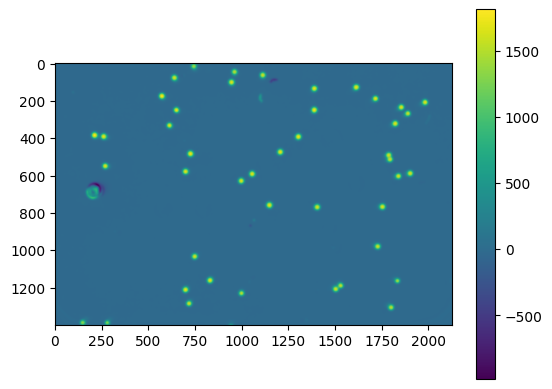

In [208]:
filtered_cropped_image = diff_merged_colours(raw_colonies, raw_background)
plt.imshow(filtered_cropped_image)
plt.colorbar()
plt.show()
plt.close()



44
[  17   47   64   79  102  129  136  176  190  209  236  251  251  269
  323  333  385  392  394  475  484  493  512  550  579  589  592  604
  629  759  768  770  980 1033 1161 1163 1189 1207 1211 1230 1284 1305
 1387 1387]


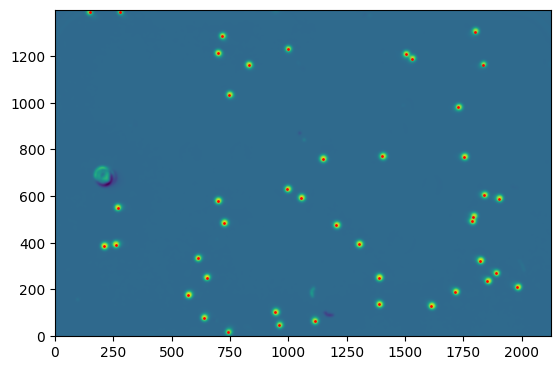

In [209]:

blurred_diff = ndi.gaussian_filter(filtered_cropped_image, sigma=5)
max_diff = ndi.maximum_filter(blurred_diff, size=int(10/2))

# aprrox_maxima = np.where(np.logical_and(max_diff == blurred_diff, np.greater(max_diff, 1000)))
aprrox_maxima = np.where(np.logical_and(max_diff == blurred_diff, np.greater(max_diff, 800)))
# aprrox_maxima = np.where(max_diff == blurred_diff)

# check_max = max_diff.copy()
# check_max[aprrox_maxima] = 0
# plt.imshow(check_max)    
# plt.show()
print(len(aprrox_maxima[0]))
# plt.imshow(diff)
if True:
    plt.imshow(filtered_cropped_image)
    plt.scatter(aprrox_maxima[1], aprrox_maxima[0], c='r', s=1)
    plt.gca().invert_yaxis()

print(aprrox_maxima[0])





In [234]:
def sort_out_maxima(maxima, diff):
    r = 5
    updated_maxima_0 = maxima[0]
    updated_maxima_1 = maxima[1]
    index_to_delete = []

    #check wether colonies are to close to each other
    for i in range(len(maxima[0])-1):
        if np.sqrt((maxima[0][i] - maxima[0][i+1])**2 + (maxima[1][i] - maxima[1][i+1])**2) < 2* r:
            if diff[maxima[0][i], maxima[1][i]] > diff[maxima[0][i+1], maxima[1][i+1]]:
                index_to_delete.append(i+1)
            else:
                index_to_delete.append(i)
    
    #check wether colony is to close to the border
    for i in range(len(updated_maxima_0)):
        if updated_maxima_0[i] < r*2 or updated_maxima_0[i] > diff.shape[0] - r*2 or updated_maxima_1[i] < r*2 or updated_maxima_1[i] > diff.shape[1] - r*2:
            index_to_delete.append(i)
        
    updated_maxima_0 = np.delete(updated_maxima_0, index_to_delete)
    updated_maxima_1 = np.delete(updated_maxima_1, index_to_delete)
    


    return [updated_maxima_0, updated_maxima_1]

def intensity_within_radius(maxima, diff, r):
    intensity = []
    for i in range(len(maxima[0])):
        y, x = maxima[0][i], maxima[1][i]
        mask = np.sqrt((maxima[0] - y)**2 + (maxima[1] - x)**2) <= r
        try:
            print(mask)
            diff[mask]
        except:
            print('error')
            break
        intensity.append(np.mean(diff[mask]))
    return intensity # sorted like maxima[0]


def radMask(index,radius,array):
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius

  return mask

if False: #set to True to check algorithm
    import time
    #meanAll is going to store ~18000 points
    meanAll=[]
    for i in range(len(aprrox_maxima[0])):
        x = aprrox_maxima[0][i]
        y = aprrox_maxima[1][i]
        centerMask=(x,y)
        mask=radMask(centerMask,5,filtered_cropped_image)
        if False:
            pl.imshow(mask)
            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.1)
        #un-mask center and values below 0
        mask[centerMask]=False
        mask[filtered_cropped_image<0]=False
        #get the mean
        meanAll.append(np.mean(filtered_cropped_image[mask]))

def get_int_within_r(maxima, image, r):
    meanAll=[]
    for i in range(len(maxima[0])):
        x = maxima[0][i]
        y = maxima[1][i]
        centerMask=(x,y)
        mask=radMask(centerMask,r,image)
        #un-mask center and values below 0
        mask[centerMask]=False
        mask[image<0]=False
        #get the mean
        meanAll.append(np.mean(image[mask]))
    return meanAll

               

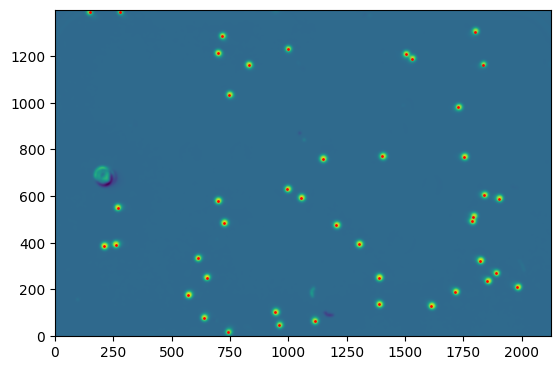

In [239]:
sorted_maxima = sort_out_maxima(aprrox_maxima, filtered_cropped_image)

plt.scatter(sorted_maxima[1], sorted_maxima[0], c='r', s=1)
plt.imshow(filtered_cropped_image)
plt.gca().invert_yaxis()
plt.show()
plt.close()


In [236]:
intensities = get_int_within_r(sorted_maxima, filtered_cropped_image, 5)

In [284]:

intensity_dict = defaultdict(list)
for index, intensity in enumerate(intensities):
    intensity_dict[index].append(intensity)


In [279]:
# for key in intensity_dict.keys():
    # intensity_dict[key].append(intensities[key])



In [313]:
x = np.arange(100)

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
